https://blog.csdn.net/u013398034/article/details/112789084

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

import os 
os.chdir(r'/content/drive/MyDrive/NTU_Course/AI6128-Urban_Computing/Lecture/Assignment1/')

Mounted at /content/drive/


In [3]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
from sample.compute import *


In [3]:
from dataclasses import dataclass
from sample.compute import *
from pathlib import Path


@dataclass
class PathData:
    # acce in sample
    acce: np.array
    # gyro in sample
    gyro: np.array
    # ahrs in sample
    ahrs: np.array
    # magn in sample
    magn: np.array
    # wifi in sample
    wifi: np.array
    # ibeacon in sample
    ibeacon: np.array
    # waypoint in sample
    waypoint: np.array


def assmble_path_data(data_lines):
    type_acc = []
    type_gyr = []
    type_rot = []
    type_mag = []
    type_mag_uncal = []
    type_gyr_uncal = []
    type_acc_uncal = []
    type_wif = []
    type_bea = []
    type_way = []

    data_type_dict = {
        'TYPE_ACCELEROMETER': type_acc,
        'TYPE_GYROSCOPE': type_gyr,
        'TYPE_ROTATION_VECTOR': type_rot,
        'TYPE_MAGNETIC_FIELD': type_mag,
        'TYPE_MAGNETIC_FIELD_UNCALIBRATED': type_mag_uncal,
        'TYPE_GYROSCOPE_UNCALIBRATED': type_gyr_uncal,
        'TYPE_ACCELEROMETER_UNCALIBRATED': type_acc_uncal,
        'TYPE_WIFI': type_wif,
        'TYPE_BEACON': type_bea,
        'TYPE_WAYPOINT': type_way
    }

    for data_line in data_lines:
        data_line = data_line.strip()

        if data_line[0] == '#' or data_line[0] is None:
            continue

        data_line = data_line.split('\t')

        if not data_type_dict.__contains__(data_line[1]):
            continue

        if data_line[1] == 'TYPE_WIFI':
            ts = data_line[0]
            bssid = data_line[3]
            rssi = data_line[4]
            wifi_data = [ts, bssid, rssi]
            type_wif.append(wifi_data)
            continue

        elif data_line[1] == 'TYPE_BEACON':
            ts = data_line[0]
            uuid = data_line[2]
            major = data_line[3]
            minor = data_line[4]
            rssi = data_line[6]
            beacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            type_bea.append(beacon_data)
            continue

        elif data_line[1] == 'TYPE_WAYPOINT':
            type_way.append([int(data_line[0]), float(data_line[2]), float(data_line[3])])
            continue

        else:
            data_type_dict[data_line[1]].append(
                [int(data_line[0]), float(data_line[2]), float(data_line[3]), float(data_line[4])])
            continue

    type_acc = np.array(type_acc)
    type_gyr = np.array(type_gyr)
    type_rot = np.array(type_rot)
    type_mag = np.array(type_mag)
    type_wif = np.array(type_wif)
    type_bea = np.array(type_bea)
    type_way = np.array(type_way)

    return PathData(type_acc, type_gyr, type_rot, type_mag, type_wif, type_bea, type_way)


def read_path_data(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    return assmble_path_data(lines)


def combine_data_with_position(path_data_files, augmentation=True):
    combined_data = {}
    for path_filename in list(Path(path_data_files).resolve().glob("*.txt")):
        print('Processing file:', path_filename)
        path_data = read_path_data(path_filename)
        acce_data = path_data.acce
        magn_data = path_data.magn
        ahrs_data = path_data.ahrs
        wifi_data = path_data.wifi
        ibeacon_data = path_data.ibeacon
        waypoint_data = path_data.waypoint

        if augmentation:
            positions = compute_step_positions(acce_data, ahrs_data, waypoint_data)
        else:
            positions = waypoint_data

        if wifi_data.size != 0:
            sep_tss_wifi = np.unique(wifi_data[:, 0].astype(float))
            wifi_data_list = split_ts_seq(wifi_data, sep_tss_wifi)
            for wifi in wifi_data_list:
                diff = np.abs(positions[:, 0] - float(wifi[0, 0]))
                index = np.argmin(diff)
                position_key = tuple(positions[index, 1:3])
                if position_key in combined_data:
                    combined_data[position_key]['wifi'] = np.append(combined_data[position_key]['wifi'], wifi, axis=0)
                else:
                    combined_data[position_key] = {
                        'magnetic': np.zeros((0, 4)),
                        'wifi': wifi,
                        'ibeacon': np.zeros((0, 3))
                    }

        if ibeacon_data.size != 0:
            sep_tss_ibeacon = np.unique(ibeacon_data[:, 0].astype(float))
            ibeacon_data_list = split_ts_seq(ibeacon_data, sep_tss_ibeacon)
            for ibeacon in ibeacon_data_list:
                diff = np.abs(positions[:, 0] - float(ibeacon[0, 0]))
                index = np.argmin(diff)
                position_key = tuple(positions[index, 1:3])
                if position_key in combined_data:
                    combined_data[position_key]['ibeacon'] = np.append(combined_data[position_key]['ibeacon'], ibeacon,
                                                                       axis=0)
                else:
                    combined_data[position_key] = {
                        'magnetic': np.zeros((0, 4)),
                        'wifi': np.zeros((0, 3)),
                        'ibeacon': ibeacon
                    }

        sep_tss_magn = np.unique(magn_data[:, 0].astype(float))
        magnetic_data_list = split_ts_seq(magn_data, sep_tss_magn)
        for magnetic in magnetic_data_list:
            diff = np.abs(positions[:, 0] - float(magnetic[0, 0]))
            index = np.argmin(diff)
            position_key = tuple(positions[index, 1:3])
            if position_key in combined_data:
                combined_data[position_key]['magnetic'] = np.append(combined_data[position_key]['magnetic'], magnetic,
                                                                    axis=0)
            else:
                combined_data[position_key] = {
                    'magnetic': magnetic,
                    'wifi': np.zeros((0, 3)),
                    'ibeacon': np.zeros((0, 3))
                }
    return combined_data

In [30]:
def extract_data(files_path):
    all_data = combine_data_with_position(files_path)
    position = []
    magn = []
    
    # w_bssid_set = list(extract_wifi_rssi(all_data).keys())
    df1_ibeacon = pd.DataFrame()
    for position_key in all_data:
        position.append(str(position_key))
        
        magn_data = all_data[position_key]['magnetic']
        magn.append(np.mean(np.sqrt(np.sum(magn_data[:, 1:4] ** 2, axis=1))))
        df =pd.DataFrame({
            'position':position,
            'magn':magn
        })

        ibeacon_data = all_data[position_key]['ibeacon']
        df2 = wrangle1_data_ibeacon(ibeacon_data)
        if df1_ibeacon.size == 0:
            df1_ibeacon = df2
        df1_ibeacon = pd.concat([df1_ibeacon,df2])
    
    df.to_csv('processed_data.csv', index=False, sep=',')
    df1_ibeacon.to_csv('df1_ibeacon.csv',index=False,sep=',')

In [31]:
def extract_ibeacon_rssi(all_data):
    ibeacon_rssi = {}
    for position_key in all_data:

        ibeacon_ds = all_data[position_key]['ibeacon']
        for ibeacon_d in ibeacon_ds:
            ummid = ibeacon_d[1]
            rssi = int(ibeacon_d[2])

            if ummid in ibeacon_rssi:
                position_rssi = ibeacon_rssi[ummid]
                if position_key in position_rssi:
                    old_rssi = position_rssi[position_key][0]
                    old_count = position_rssi[position_key][1]
                    position_rssi[position_key][0] = (old_rssi * old_count + rssi) / (old_count + 1)
                    position_rssi[position_key][1] = old_count + 1
                else:
                    position_rssi[position_key] = np.array([rssi, 1])
            else:
                position_rssi = {}
                position_rssi[position_key] = np.array([rssi, 1])

            ibeacon_rssi[ummid] = position_rssi

    return ibeacon_rssi

In [32]:
def extract_wifi_rssi(all_data):
    wifi_rssi = {}
    for position_key in all_data:
        wifi_ds = all_data[position_key]['wifi']
        for wifi_d in wifi_ds:
            bssid = wifi_d[1]
            rssi = int(wifi_d[2])

            if bssid in wifi_rssi:
                position_rssi = wifi_rssi[bssid]
                if position_key in position_rssi:
                    rssi = position_rssi[position_key][0]
                    wifi_count = position_rssi[position_key][1]
                    position_rssi[position_key][0] = (rssi * (wifi_count + 1)) / (wifi_count + 1)
                    position_rssi[position_key][1] += 1
                else:
                    position_rssi[position_key] = [rssi, 1]
            else:
                position_rssi = {position_key: [rssi, 1]}

            wifi_rssi[bssid] = position_rssi

    return wifi_rssi

In [34]:
def extract_data(files_path, augmentation=True, one_position=False, use_wifi=True, use_ibeacon=True):
    import csv

    all_data = combine_data_with_position(files_path, augmentation)

    wifi_rssi = extract_wifi_rssi(all_data)
    ibeacon_rssi = extract_ibeacon_rssi(all_data)
    
    wifi_bssid = list(wifi_rssi.keys())
    ibeacon_ummid = list(ibeacon_rssi.keys())

    wifi_bssid_length = 0
    ibeacon_ummid_length = 0
    if one_position:
        begin_idx = 2
        index = ['position', 'magn_strength']
    else:
        begin_idx = 3
        index = ['position_x', 'position_y', 'magn_strength']

    if use_wifi:
        wifi_bssid_length = len(wifi_bssid)
        index.extend(wifi_bssid)
    
    if use_ibeacon:
        ibeacon_ummid_length = len(ibeacon_ummid)
        index.extend(ibeacon_ummid)

    data_file_path = 'data_for_train_site1_f1.csv'
    with open(data_file_path, newline='', mode='w') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerow(index)

        for position_key in all_data:

            row_data = []

            # write position data
            if one_position:
                row_data.append(str(position_key))
            else:
                row_data.append(position_key[0])
                row_data.append(position_key[1])

            # write magnetic strength
            magnetic_data = all_data[position_key]['magnetic']
            magn_stength = np.mean(np.sqrt(np.sum(magnetic_data[:, 1:4] ** 2, axis=1)))
            row_data.append(magn_stength)

            # write wifi rssi
            if use_wifi:
                for bssid in index[begin_idx: begin_idx + wifi_bssid_length]:
                    if position_key in wifi_rssi[bssid]:
                        row_data.append(wifi_rssi[bssid][position_key][0])
                    else:
                        row_data.append(0)

            # write ibeacon rssi
            if use_ibeacon:
                for ummid in index[begin_idx + wifi_bssid_length: begin_idx + wifi_bssid_length+ibeacon_ummid_length]:
                    if position_key in ibeacon_rssi[ummid]:
                        row_data.append(ibeacon_rssi[ummid][position_key][0])
                    else:
                        row_data.append(0)


            csv_writer.writerow(row_data)
        
        print('The csv file is completed')

In [35]:
import pandas as pd

# path = './data/site1/B1/path_data_files/'
# extract_data = extract_data(path)

files_path = os.path.join('./data/', 'site1', 'F1', 'path_data_files')
extract_data(files_path, one_position=False, use_wifi=False, use_ibeacon=False)

Processing file: /content/drive/MyDrive/NTU_Course/AI6128-Urban_Computing/Lecture/Assignment1/data/site1/F1/path_data_files/5dd9e7aac5b77e0006b1732b.txt
Processing file: /content/drive/MyDrive/NTU_Course/AI6128-Urban_Computing/Lecture/Assignment1/data/site1/F1/path_data_files/5dd9e7abc5b77e0006b1732d.txt
Processing file: /content/drive/MyDrive/NTU_Course/AI6128-Urban_Computing/Lecture/Assignment1/data/site1/F1/path_data_files/5dd9e7b29191710006b5705b.txt
Processing file: /content/drive/MyDrive/NTU_Course/AI6128-Urban_Computing/Lecture/Assignment1/data/site1/F1/path_data_files/5dd9e7b7c5b77e0006b1732f.txt
Processing file: /content/drive/MyDrive/NTU_Course/AI6128-Urban_Computing/Lecture/Assignment1/data/site1/F1/path_data_files/5dd9e7ba9191710006b5705d.txt
Processing file: /content/drive/MyDrive/NTU_Course/AI6128-Urban_Computing/Lecture/Assignment1/data/site1/F1/path_data_files/5dd9e7bdc5b77e0006b17331.txt
Processing file: /content/drive/MyDrive/NTU_Course/AI6128-Urban_Computing/Lecture/

Streaming output truncated to the last 5000 lines.
        [[0.8544, 0.7034]],

        [[0.8544, 0.7034]]], device='cuda:0', grad_fn=<ViewBackward0>)
labels: tensor([[[0.8743, 0.6975]],

        [[0.8705, 0.6948]],

        [[0.8668, 0.6925]],

        [[0.8633, 0.6899]],

        [[0.8520, 0.6828]],

        [[0.8668, 0.7036]],

        [[0.8897, 0.7088]],

        [[0.8926, 0.7096]],

        [[0.8992, 0.7110]],

        [[0.9099, 0.7124]]], device='cuda:0')
predict: tensor([[[0.8513, 0.7028]],

        [[0.8513, 0.7028]],

        [[0.8513, 0.7028]],

        [[0.8513, 0.7028]],

        [[0.8513, 0.7028]],

        [[0.8513, 0.7028]],

        [[0.8513, 0.7028]],

        [[0.8513, 0.7028]],

        [[0.8513, 0.7028]],

        [[0.8513, 0.7028]]], device='cuda:0', grad_fn=<ViewBackward0>)
labels: tensor([[[0.9081, 0.7110]],

        [[0.9046, 0.7106]],

        [[0.8784, 0.6999]],

        [[0.8562, 0.6854]],

        [[0.8540, 0.6840]],

        [[0.8476, 0.6894]],

        [[0

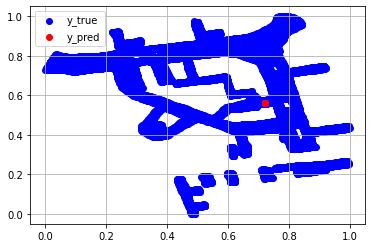

In [8]:
import numpy as np
from torch import nn
import pandas as pd
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
from plotly import graph_objects as go
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

def wrangle_dataset(dataset, n_pred, n_nxt):
    '''
    Wrangle dataset
    '''
    dim = dataset.shape[1]
    train_x, train_y = [], []
    for i in range(dataset.shape[0] - n_pred - n_nxt - 1):
        a = dataset[i:(i + n_pred), :]
        train_x.append(a)
        tmp = dataset[(i + n_pred):(i + n_pred + n_nxt), :]
        b = []
        for j in range(len(tmp)):
            for k in range(dim):
                b.append(tmp[j, k])
        train_y.append(b)
    train_x = np.array(train_x, dtype='float64')
    train_y = np.array(train_y, dtype='float64')

    test_x, test_y = [], []
    i = dataset.shape[0] - n_pred - n_nxt - 1
    a = dataset[i:(i + n_pred), :]
    test_x.append(a)
    tmp = dataset[(i + n_pred):(i + n_pred + n_nxt), :]
    b = []
    for j in range(len(tmp)):
        for k in range(dim):
            b.append(tmp[j, k])
    test_y.append(b)
    test_x = np.array(test_x, dtype='float64')
    test_y = np.array(test_y, dtype='float64')

    return train_x, train_y, test_x, test_y

def Normalized(dataset, flag):
    '''
    normalization
    '''
    normalization = np.arange(2 * dataset.shape[1], dtype='float64')
    normalization = normalization.reshape(dataset.shape[1], 2)

    for i in range(0, dataset.shape[1]):
        if flag == True:
            list = dataset[:, i]
            listlow, listhigh = np.percentile(list, [0, 100])
        else:
            if i == 0:
                listlow = -100
                listhigh = 100
            else:
                listlow = -200
                listhigh = 200

        normalization[i, 0] = listlow
        normalization[i, 1] = listhigh

        delta = listhigh - listlow
        if delta != 0:
            for j in range(0, dataset.shape[0]):
                dataset[j, i] = (dataset[j, i] - listlow) / delta

    return dataset, normalization

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # inputs are x, y waypoints
        self.lstm = nn.LSTM(input_size=2, hidden_size=6, num_layers=3, batch_first=True)   
        # output for waypoint trajectory
        self.fc = nn.Linear(in_features=6, out_features=2)  

    def forward(self, x):
        # x is input, size (batch_size, seq_len, input_size)
        x, _ = self.lstm(x)
        # x is output, size (batch_size, seq_len, hidden_size)
        x = x[:, -1, :]
        x = self.fc(x)
        x = x.view(-1, 1, 2) 
        return x

def step(model, features, labels):
    # forward path to get loss
    predict = model.forward(features)
    print('predict:', predict)
    print('labels:', labels)
    loss = loss_function(predict, labels)
    # backward
    loss.backward()
    # update 
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

# train
def train(model, epochs):
    for epoch in range(1, epochs + 1):
        list_loss = []
        for features, labels in dl_train:
            loss_i = step(model, features, labels)
            list_loss.append(loss_i)
        loss = np.mean(list_loss)
        if epoch % 10 == 0:
            print('epoch={} | loss={} '.format(epoch, loss))
    print("finish training")
    save_path = './myLstm_site1_f1.pth'
    torch.save(model.state_dict(), save_path)

# def plot_Loss_Curve(train_losses,epoch):
#     plt.figure(figsize = (6,4),dpi = 200)
#     plt.xlim(0, epoch+1)
#     plt.plot(range(1,len(train_losses)+1), train_losses, 'b')
#     # plt.plot(range(1,len(test_losses)+1), test_losses, 'r')
#     plt.xlabel("Number of epochs")
#     plt.ylabel("Loss")
#     plt.title("Loss vs Number of epochs")
#     # plt.legend(legend)
#     plt.show()

if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    n_pred = 9
    n_nxt = 1
    flag = True
    
    # read dataset 
    dataset = pd.read_csv('data_for_train_site1_f1.csv', sep=',').iloc[:, :2].values
    print('dataset shape:',dataset.shape)
    print("samples：{0}，dim：{1}".format(dataset.shape[0], dataset.shape[1]))
    # print(dataset)

    # normalization
    dataset, normalization = Normalized(dataset, flag)

    # create train and test dataset
    x_train, y_train, test_x, test_y = wrangle_dataset(dataset, n_pred, n_nxt)


    model = MyNet().to(device)
    # model.load_state_dict(torch.load('myLstm2.pth'))
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    x_train = torch.tensor(x_train.reshape(-1, n_pred, 2), dtype=torch.float).to(device)
    y_train = torch.tensor(y_train.reshape(-1, 1, 2), dtype=torch.float).to(device)
    print('y_train.shape： ', y_train.shape, 'y_train.shape：', y_train.shape)

    batch_size = 10
    ds_train = TensorDataset(x_train, y_train)
    dl_train = DataLoader(ds_train, batch_size=batch_size, num_workers=0)

    # train
    train(model, 100)

    # loss_t = []
    # for epoch in range(1, 6):
    #     list_loss = []
    #     for features, labels in dl_train:
    #         loss_i = step(model, features, labels)
    #         list_loss.append(loss_i)
    #     loss = np.mean(list_loss)
    #     loss_t.append(loss)
    #     if epoch % 10 == 0:
    #         print('epoch={} | loss={} '.format(epoch, loss))
    # print("finish training")
    # save_path = './myLstm_site1_f1.pth'
    # torch.save(model.state_dict(), save_path)

    # predict
    y_true = y_train.squeeze().cpu().numpy()
    print("y_true.shape:",y_true.shape)
    y_pred = model.forward(x_train).detach().squeeze().cpu().numpy()
    print("y_pred.shape:", y_pred.shape)

    # plot trajectory
    plt.scatter(y_true[:, 1], y_true[:, 0], c='b', marker='o', label='y_true')
    plt.scatter(y_pred[:, 1], y_pred[:, 0], c='r', marker='o', label='y_pred')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()